Time Series Analisys for Soy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from sklearn.linear_model import LinearRegression

from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Variables of soybeans and soy sub-products
soyMeal = yf.Ticker('ZM=F')
soyOil = yf.Ticker('ZL=F')
soybean = yf.Ticker('ZS=F')

soyMeal = soyMeal.history(period="max")
soyOil = soyOil.history(period="max")
soybean = soybean.history(period="max")

# Lists I use for manipulating the dataframe for each commodity
# commodities = [soyMeal]
commodities = [soyOil]
# commodities = [soybean]
# commodityName = 'soyMeal'
commodityName = 'soyOil'
# commodityName = 'soybean'



In [3]:
# Drop all columns except date and close price, rename close price to name of the commodity
col2drop = ['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits']
count = 0

for i in commodities:
    i.drop(columns = col2drop, axis = 0, inplace = True)
    i.columns = [[commodityName][count]]
    count += 1

In [4]:
# Join all data frames into one
df = pd.concat(commodities, join='outer', axis=1)

# Some prices are missing for things like holidays, use forward fill to make the missing values the same as the previous
df.ffill()
df.dropna()

,soyOil
Date,
2000-03-15,16.850000
2000-03-16,16.940001
2000-03-17,17.850000
2000-03-20,17.459999
2000-03-21,17.270000
...,...
2022-03-14,78.730003
2022-03-15,73.680000
2022-03-16,73.550003


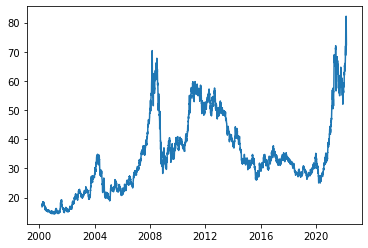

In [5]:
plt.plot(df);

In [6]:
#df_copy = df.reset_index(level=0)

In [7]:
# Filtrando os dados anteriores ao ano 2000 (Nao temos todos os dias desse ano)
#df_copy = df_copy[df_copy['Date']>"2000-12-31"]

In [8]:
#df_copy = df_copy.drop(columns = "Date")

In [9]:
#df_copy = df_copy.set_index("Date")
#df_copy

In [10]:
y = df.values


In [11]:
# let's keep the last 40% values out for test purposes
train_size = 0.6
index = round(train_size*df.shape[0])
df_train = df.iloc[:index]
df_test = df.iloc[index:]

In [12]:
y_pred = df_test.shift(1)
y_pred

,soyOil
Date,
2013-07-30,NaN
2013-07-31,42.110001
2013-08-01,42.090000
2013-08-02,42.490002
2013-08-05,42.380001
...,...
2022-03-14,82.180000
2022-03-15,78.730003
2022-03-16,73.680000


In [13]:
from sklearn.metrics import r2_score

y_pred = df_test.shift(1).dropna()
y_true = df_test[1:]
print(f"R2:{r2_score(y_true, y_pred)}")

R2:0.9965582352702379


# Linear model with 12 auto-regressive features

In [14]:
df2 = df.copy()
df2_train = df_train.copy()
df2_test = df_test.copy()

for i in range(1, 13):
    df2_train[f't - {i}'] = df_train[commodityName].shift(i)
    df2_test[f't - {i}'] = df_test[commodityName].shift(i)

df2_train.dropna(inplace=True)    
df2_test.dropna(inplace=True)    
df2_train.head()

,soyOil,t - 1,t - 2,t - 3,t - 4,t - 5,t - 6,t - 7,t - 8,t - 9,t - 10,t - 11,t - 12
Date,,,,,,,,,,,,,
2000-03-31,18.309999,17.879999,17.790001,17.500000,17.600000,17.400000,17.160000,17.50,17.27,17.459999,17.850000,16.940001,16.850000
2000-04-03,18.540001,18.309999,17.879999,17.790001,17.500000,17.600000,17.400000,17.16,17.50,17.270000,17.459999,17.850000,16.940001
2000-04-04,18.389999,18.540001,18.309999,17.879999,17.790001,17.500000,17.600000,17.40,17.16,17.500000,17.270000,17.459999,17.850000
2000-04-05,18.480000,18.389999,18.540001,18.309999,17.879999,17.790001,17.500000,17.60,17.40,17.160000,17.500000,17.270000,17.459999
2000-04-06,17.840000,18.480000,18.389999,18.540001,18.309999,17.879999,17.790001,17.50,17.60,17.400000,17.160000,17.500000,17.270000


In [15]:
# Train Test Split
X2_train = df2_train.drop(columns = [commodityName])
y2_train = df2_train[commodityName]
X2_test = df2_test.drop(columns = [commodityName])
y2_test = df2_test[commodityName]

print(X2_train.shape,y2_train.shape, X2_test.shape,y2_test.shape)

(3249, 12) (3249,) (2162, 12) (2162,)


R2:  0.996555711047861


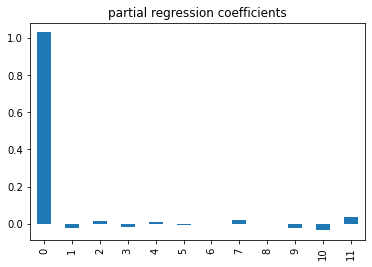

In [16]:
# Predict and measure R2
model = LinearRegression()
model = model.fit(X2_train, y2_train)

print('R2: ', r2_score(y2_test, model.predict(X2_test)))
pd.Series(model.coef_).plot(kind='bar')
plt.title('partial regression coefficients');

Only the 12th coefficient convey some information to the model (a Linear Regression based on these 12 autoregressive features)

Except for the 12th coefficient, most of the prediction is done by the intercept (basically predicting the mean of the last 12 values)

All the other features are statistically insignificant (high p-values)

## Decomposition

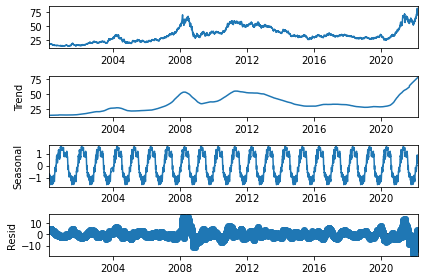

In [17]:
# Additive Decomposition (y = Trend + Seasonal + Residuals)
result_add = seasonal_decompose(df, model='additive', period = 253, extrapolate_trend='freq')
result_add.plot();

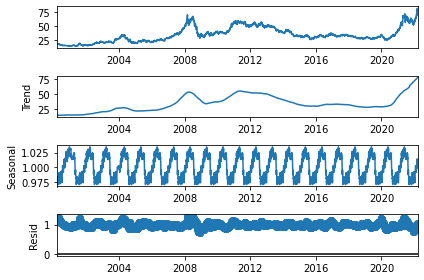

In [18]:
# Multiplicative Decomposition (y = Trend * Seasonal * Residuals)
result_mul = seasonal_decompose(df, model='multiplicative', period = 253, extrapolate_trend='freq')

result_mul.plot();

In [19]:
print(df.head(1))
print(result_add.trend[0] + result_add.seasonal[0] + result_add.resid[0])
print(result_mul.trend[0] * result_mul.seasonal[0] * result_mul.resid[0])

            soyOil
Date              
2000-03-15   16.85
16.850000381469727
16.850000381469727


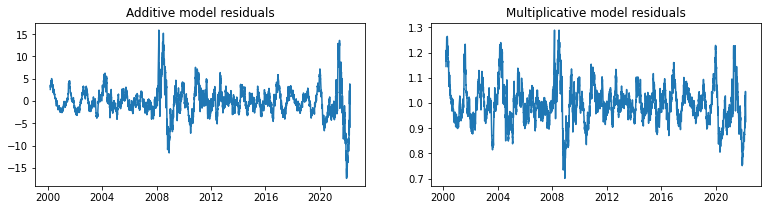

In [20]:
# Plot the residuals with "result_add.resid" to decide
f, (ax1, ax2) = plt.subplots(1,2, figsize=(13,3))
ax1.plot(result_add.resid); ax1.set_title("Additive model residuals")
ax2.plot(result_mul.resid); ax2.set_title("Multiplicative model residuals");

☝️ Additive and Multiplicative residuals seem to have| "stationarity"

## Testing the stationarity of our series

Augmented Dickey Fuller - ADF Tests


ADF tests the following null hypothesis:

H0 : The series is not-stationary.

A p-value close to 0 (e.g. p < 0.05) indicates stationarity.

In [21]:
from statsmodels.tsa.stattools import adfuller

adfuller(df[commodityName])[1]  # p-value

0.706724491674935

In [22]:
# Sem nenhuma diferenciacao a serie nao eh estacionario, p-value > 0.05

In [23]:
print('additive resid: ', adfuller(result_add.resid.dropna())[1])
print('multipl resid: ', adfuller(result_mul.resid.dropna())[1])

additive resid:  1.248281370393321e-09
multipl resid:  5.56404659026371e-11


☝️ p-values of the residuals are below 0.05, therefore we cannot discard the possibilities of our H0

Storing the results into the DataFrame for the multiplicative results:

In [24]:
df['trend'] = result_mul.trend
df['season'] = result_mul.seasonal
df['resid'] = result_mul.resid
df.head()

,soyOil,trend,season,resid
Date,,,,
2000-03-15,16.850000,15.065037,0.976864,1.144973
2000-03-16,16.940001,15.067890,0.978058,1.149466
2000-03-17,17.850000,15.070742,0.979745,1.208900
2000-03-20,17.459999,15.073595,0.983822,1.177365
2000-03-21,17.270000,15.076447,0.979718,1.169209


## Autocorrelation (ACF) and Partial Autocorrelation (AR / PACF)

### Autocorrelation - Direct and Indirect impact of previous values against the present one

The autocorrelation statistic measures how much does a value that is $n$ moments (hours, days, months, years, etc.) impacts the present value, both directly and indirectly.
<img width="700" src='attachment:image.png'>

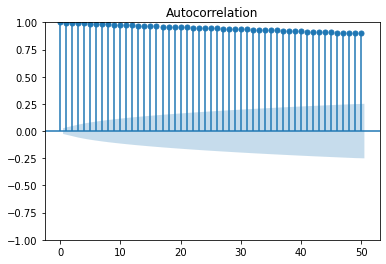

In [25]:
from statsmodels.graphics.tsaplots import plot_acf

# let's see the acf for every value from 1 up to 50 "lags" before the actual one
plot_acf(df[commodityName], lags=50)
plt.show()

### Partial Autocorrelation - Direct impact only

/Users/alexandre/.pyenv/versions/3.8.12/envs/commodities/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


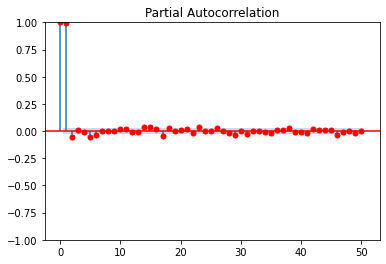

In [26]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df[commodityName], lags=50, c='r')
plt.show()

The values shown in the graph above are the same as the ACF ones: they are correlations. However, AR removes the indirect correlation that past values might have between each other. So now, we can see that the **month before the actual** has a great correlation, but looking at two months before won't give us as much information. Looking 12 months behind, as expected, will also give us a high correlation by itself because of the seasonality

## ARIMA - Auto Regressive Integrated Moving Average

To recap things, so far we've seen how:
- a value in a Time Series can be caculated by a combination of trend, seasonality and residuals
- we need to difference our data in order to make it stationary (and we can diff it as many times as needed)
- Auto Regression (AR) shows how much does values prior to the actual one **directly** impact it
- Moving Averages (MA) shows how far is the actual value to an average of some values prior to it

By combining these informations, clever people got to an interesting model called ARIMA. In it, we need to decide three parameters:
- The amount of months prior the actual one to auto regress (which we'll call $p$) 🤔 12 months
- The amount of times we'll diff our values to make them stationary (which we'll call $i$) 🤔 We need to test it accordingly
- The amount of months to get the average and test against the actual one (which we'll call $q$) 🤔 lets give it a test too

### Differencing

In [27]:
# diffed_one = df.diff()
# diffed_one = diffed_one.dropna(inplace=True)
# diffed_one

<AxesSubplot:xlabel='Date'>

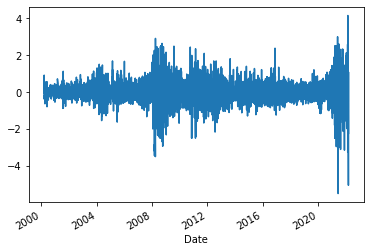

In [28]:
diffed_values = df[commodityName].diff()
diffed_values.dropna(inplace=True)
diffed_values.plot()

In [29]:
adfuller(diffed_values)[1]

4.449665174205102e-20

/Users/alexandre/.pyenv/versions/3.8.12/envs/commodities/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


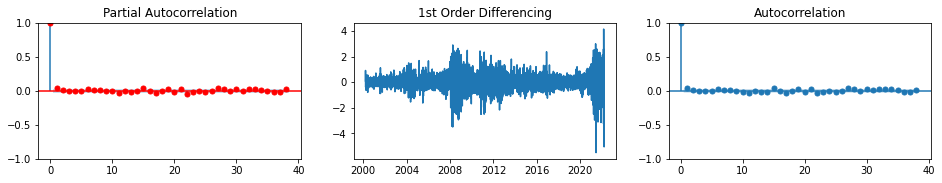

In [30]:
# ACF / PACF analysis of y_diff linearized
fig, axes = plt.subplots(1,3, figsize=(16,2.5))
plot_pacf(diffed_values, ax=axes[0], c='r');
axes[1].plot(diffed_values); axes[1].set_title('1st Order Differencing')
plot_acf(diffed_values, ax=axes[2]);

- With PACF, you'll be able to find $p$ by looking at how many dots you have **before the first one reaches the confidence area**
- With 1st Order Differencing, you'll be able to check if your data is stationary. If not, diff it again (**but not too much**)
- With ACF, you'll be able to find $q$ by looking at how many dots you have **before the first one reaches the confidence area**

In our case, $p = 1, i = 1, q = 1$

In [31]:
from statsmodels.tsa.arima.model import ARIMA #statsmodels 0.11
#from statsmodels.tsa.arima.model import ARIMA #statsmodels 0.12

arima = ARIMA(df[commodityName], order=(1,1,1))
arima = arima.fit()
arima.summary()

/Users/alexandre/.pyenv/versions/3.8.12/envs/commodities/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexandre/.pyenv/versions/3.8.12/envs/commodities/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexandre/.pyenv/versions/3.8.12/envs/commodities/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 soyOil   No. Observations:                 5435
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4965.753
Date:                Fri, 18 Mar 2022   AIC                           9937.506
Time:                        17:29:08   BIC                           9957.308
Sample:                             0   HQIC                          9944.417
                               - 5435                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2084      0.144      1.451      0.147      -0.073       0.490
ma.L1         -0.1618      0.144     -1.121      0.262      -0.445       0.121
sigma2         0.3641      0.003    109.537      0.000       0.358       0.371
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11781.81
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               3.21   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Interpretar o resultado:

> Equacao da soja = 0.2165 + 0.558price_soy - 0.5789price_soy

> Intercept = const >>> nao eh estatisticamente significante, Pz eh 0.334 (> 0.05)
> Coef de AR e MA, sao significante, Pz igual a 0.023 e 0.017

> Cada dia que passa o valor da soja aumenta (AR coef > 0), para cada valor da soja, o aumento eh de 0.558 
Em contrapartida, o valor da moving average (coef <0), impacta ao contrario, reduz o valor para -0.5789

/Users/alexandre/.pyenv/versions/3.8.12/envs/commodities/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


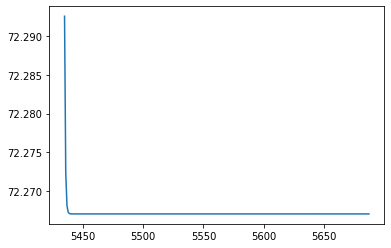

In [32]:
plt.plot(arima.forecast(253))

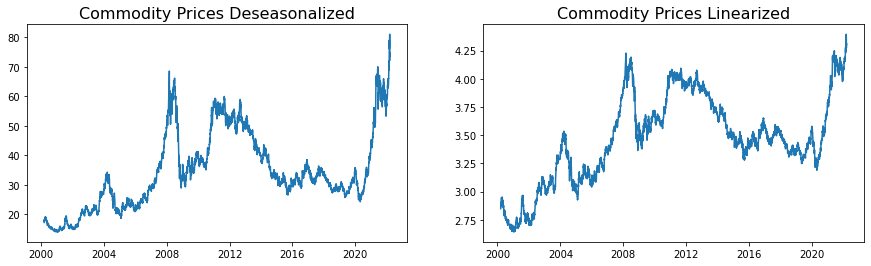

In [33]:
# Let's remove seasons
df['deseasonalized'] = df[commodityName].values/result_mul.seasonal

plt.figure(figsize=(15,4)); plt.subplot(1,2,1); plt.plot(df.deseasonalized);
plt.title('Commodity Prices Deseasonalized', fontsize=16);

# Also remove exponential trend 
df['linearized'] = np.log(df['deseasonalized'])

plt.subplot(1,2,2); plt.plot(df['linearized'])
plt.title('Commodity Prices Linearized', fontsize=16);